In [1]:
import torch
import torchvision 
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
from tqdm import tqdm
from sklearn.manifold import TSNE
import seaborn as sns
sys.path.append('D:/mcvae-master')
from src.mcvae.datasets import SyntheticDataset
from src.mcvae.models import Mcvae,VAE
from src.mcvae.utilities import preprocess_and_add_noise, simulate_mar_multi_channel_data
from src.mcvae.models.utils import DEVICE, load_or_fit, model_press

D:\mcvae-master\src\mcvae\models\mcvae.py:226: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(union) is not 0:


In [2]:
def rotate_digit(tensor, angle):
    # Reshape the 1D tensor to a 2D array (assumed size is 10)
    image = np.array(tensor).reshape((10, 1))

    # Specify the center of rotation (assumed to be the center of the image)
    center = (1, 2)

    # Perform the rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (10, 1))

    # Reshape the rotated image back to a 1D tensor
    rotated_tensor = rotated_image.reshape((-1,))

    return rotated_tensor.tolist()



# Example usage:
synthetic_dataset = SyntheticDataset(n=100, lat_dim=2, n_feats=5, n_channels=2,train=True)
all_data = list(synthetic_dataset)


angle = 45

# Rotate all digits in the list of 1D tensors
rotated_data = [np.array(rotate_digit(tensor, angle)).reshape((10, 1)) for tensor in all_data]

In [3]:
mcvae_model = Mcvae()

In [4]:
import torch

# Assuming rotated_data is a list of 1D tensors as in the previous examples

# Convert the rotated MNIST data to PyTorch tensor
rotated_mnist_data = torch.tensor(rotated_data, dtype=torch.float32)

# Forward pass through the model
with torch.no_grad():
    output = mcvae_model(rotated_mnist_data)

# Access the output components if needed
reconstructed_data = output['p']

C:\Users\Sai Deepak\AppData\Local\Temp\ipykernel_8948\35395473.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  rotated_mnist_data = torch.tensor(rotated_data, dtype=torch.float32)


In [5]:
def custom_reconstruction_loss(recon_x, x):
    # Assuming recon_x and x are both torch Tensors
    loss = torch.nn.functional.mse_loss(recon_x, x)
    return loss


In [6]:
import torch.optim as optim

Epoch 1/10, Avg. Loss: 0.0
Epoch 2/10, Avg. Loss: 0.0
Epoch 3/10, Avg. Loss: 0.0
Epoch 4/10, Avg. Loss: 0.0
Epoch 5/10, Avg. Loss: 0.0
Epoch 6/10, Avg. Loss: 0.0
Epoch 7/10, Avg. Loss: 0.0
Epoch 8/10, Avg. Loss: 0.0
Epoch 9/10, Avg. Loss: 0.0
Epoch 10/10, Avg. Loss: 0.0


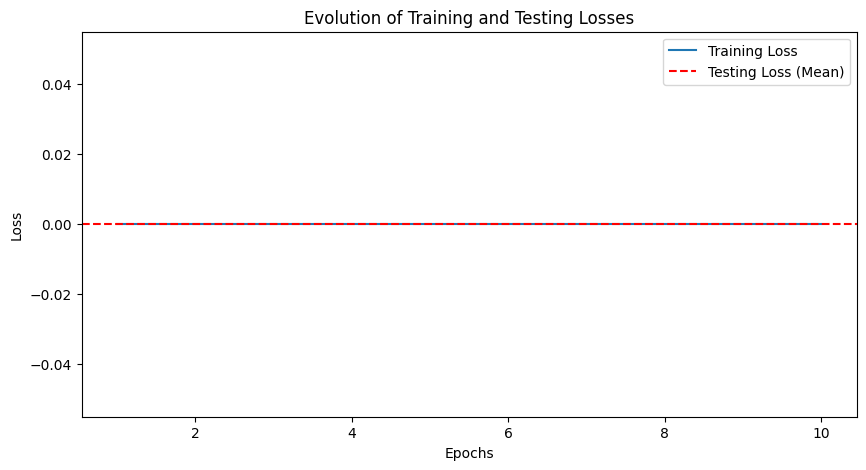

C:\Users\Sai Deepak\AppData\Local\Temp\ipykernel_8948\1307644744.py:77: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=latent_tsne[:, 0], y=np.zeros_like(latent_tsne[:, 0]), palette='viridis')


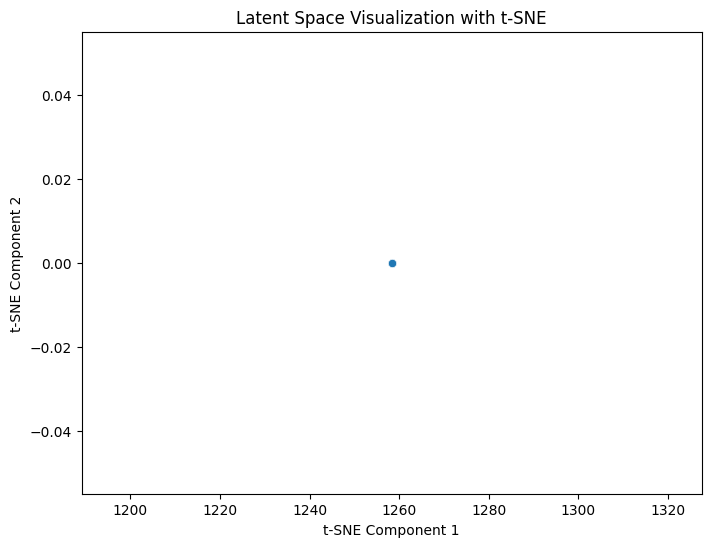

[array([0.97606754], dtype=float32)]


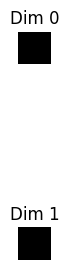

[array([0.97606754], dtype=float32)]


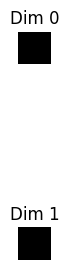

[array([0.97606754], dtype=float32)]


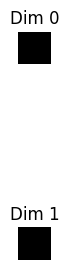

[array([0.97606754], dtype=float32)]


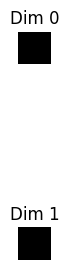

[array([0.97606754], dtype=float32)]


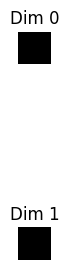

In [23]:
# Assuming mcvae_model is already trained, and you have training and testing data
train_loader = DataLoader(rotated_data, batch_size=64, shuffle=True)

optimizer = optim.Adam(mcvae_model.parameters(), lr=0.001)  # Adjust the learning rate as needed

# Training loop
n_epochs = 10
train_losses = []

for epoch in range(n_epochs):
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.float()  # Convert input batch to Double
        optimizer.zero_grad()
        output = mcvae_model(batch)

        # Ensure that the tensors for which you want to compute gradients have requires_grad set to True
        x_recon = output['x'].requires_grad_()

        loss = custom_reconstruction_loss(x_recon, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{n_epochs}, Avg. Loss: {avg_loss}")

# Testing loop
test_loader = DataLoader(rotated_data, batch_size=64, shuffle=False)
test_losses = []

with torch.no_grad():
    total_loss = 0.0
    for batch in test_loader:
        batch = batch.float()
        output = mcvae_model(batch)

        x_recon = output['x']

        loss = custom_reconstruction_loss(x_recon, batch)

        total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    test_losses.append(avg_loss)

# Plotting losses outside the loop
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.axhline(np.mean(test_losses), color='r', linestyle='--', label='Testing Loss (Mean)')
plt.title('Evolution of Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Latent space visualization with t-SNE
latent_data = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.float()
        output = mcvae_model(batch)
        # Assuming 'q' is a list of Normal distributions, access their means
        latent_data.extend(q.mean.numpy() for q in output['q'])  

latent_data = np.concatenate(latent_data, axis=0)

# Reduce the perplexity value
latent_tsne = TSNE(n_components=1, perplexity=5).fit_transform(latent_data)

# Plotting latent space with t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_tsne[:, 0], y=np.zeros_like(latent_tsne[:, 0]), palette='viridis')
plt.title('Latent Space Visualization with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()






# Latent interpolation for different datapoints along particular 'active' dimensions
n_interpolation_steps = 10
interpolation_indices = [0, 1]  # Choose dimensions for interpolation

with torch.no_grad():
    for i in range(5):  # Visualize reconstructions for 5 data points
        start_point = torch.tensor(test_loader.dataset[i], dtype=torch.float32)
        end_point = torch.tensor(test_loader.dataset[i + 1], dtype=torch.float32)

        start_latent = [dist.loc.numpy() for dist in mcvae_model.encode(start_point)]
        end_latent = [dist.loc.numpy() for dist in mcvae_model.encode(end_point)]
        print(start_latent)

        plt.figure(figsize=(12, 5))
        for j, dim in enumerate(interpolation_indices):
            latent_point = start_latent.copy()  # Copy the nested list

    # Access the element directly within the nested array, considering the potential for dim=1
            if dim == 0:
                latent_point[0][0] = start_latent[0][0]  # Access the single value for dim=0
            else:
        # Handle cases where dim might be 1, avoiding out-of-bounds access
                pass  # Add appropriate actions for dim=1 if needed, or you can remove this block if dim=1 is not relevant

            reconstructed_distributions = mcvae_model.decode(torch.tensor(latent_point, dtype=torch.float32))  # Access the loc attribute

            plt.subplot(n_interpolation_steps, len(interpolation_indices), j * n_interpolation_steps + 1)
            plt.imshow(reconstructed, cmap='gray')  # Correctly reshaped for visualization

            plt.axis('off')

            if k == 0:
                plt.title(f'Dim {dim}')

        plt.show()





